העלמת כיריים עם SD
מה הוא עושה:

DETR: אוסף כל ה־stove מעל threshold

בוחר את ה־stove לפי score וגם area מינימלי (כדי להימנע מבוקס קטן מדי)

SAM: multimask_output=False (כמו שעבד לך)

SD Inpaint: עם Textual Inversion token

שומר: orig.png, detr_boxes.png, mask.png, result.png

DEVICE: cuda
1) DETR...
✅ DETR chose stove score=0.46 area=870.1 box=[145.08379   57.33464  177.48122   84.191895]
2) SAM...
3) SD Inpaint + TI...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\adiha\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\adiha\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  33%|███▎      | 2/6 [00:00<00:00,  6.54it/s]An error occurred while trying to fetch C:\Users\adiha\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\adiha\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aed

✅ Saved to outputs_stove_clean_v3: orig.png, detr_boxes.png, mask.png, result.png


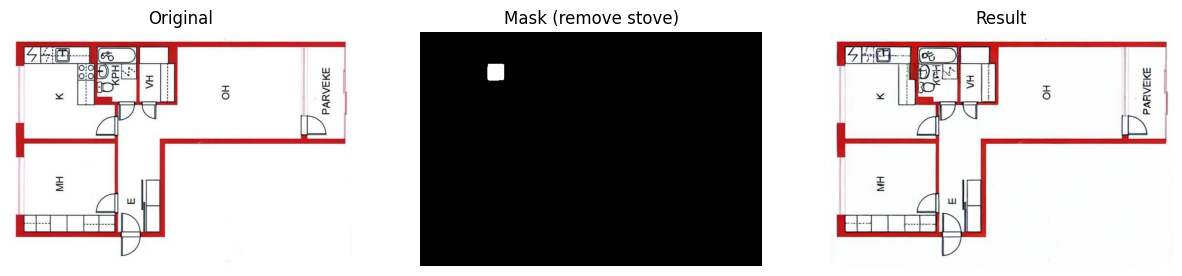

DONE ✅


In [8]:
import os, gc
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection
from segment_anything import sam_model_registry, SamPredictor
from diffusers import StableDiffusionInpaintPipeline

# =========================
# CONFIG
# =========================
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
SAM_CHECKPOINT  = r".\checkpoints\sam_vit_h_4b8939.pth"
IMAGE_PATH      = r".\TestPlans\testPlan3.PNG"

TI_TOKEN  = "<bgwhite_v1>"
TI_EMBEDS = r".\ti_bgwhite_v1\learned_embeds.safetensors"

TARGET_LABEL = "stove"
DETR_THRESH  = 0.25

# IMPORTANT: small pad only (large pad caused wall mask)
SAM_BOX_PAD = 12

PROMPT = f"{TI_TOKEN}, top down architectural floor plan background, clean empty white space, seamless"
NEG    = "stove, cooktop, hob, burners, appliance, furniture, text, watermark, noisy, blurry, shadow"

STRENGTH = 0.65
STEPS    = 25
GUIDANCE = 6.5
SEED     = 42

OUT_DIR = "outputs_stove_clean_v3"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if DEVICE == "cuda" else torch.float32
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return np.array([x0,y0,x1,y1], dtype=np.float32)

def to_multiple_of_8(w, h):
    return w - (w % 8), h - (h % 8)

def draw_boxes(img_pil, boxes, color=(255,0,0)):
    arr = np.array(img_pil).copy()
    for b in boxes:
        x0,y0,x1,y1 = map(int, b)
        cv2.rectangle(arr, (x0,y0), (x1,y1), color, 2)
    return Image.fromarray(arr)

def keep_largest_component(mask_uint8):
    m = (mask_uint8 > 127).astype(np.uint8)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1:
        return mask_uint8
    areas = stats[1:, cv2.CC_STAT_AREA]
    best = 1 + int(np.argmax(areas))
    return (labels == best).astype(np.uint8) * 255

# =========================
# 1) DETR detect (collect ALL stoves, choose best)
# =========================
print("1) DETR...")
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

# collect stove candidates
cands = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    if name != TARGET_LABEL:
        continue
    b = bx.detach().cpu().numpy()
    x0,y0,x1,y1 = b
    area = max(1.0, (x1-x0)*(y1-y0))
    cands.append((float(sc), float(area), b))

# cleanup DETR
del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

if not cands:
    raise RuntimeError(f"No '{TARGET_LABEL}' found. Try DETR_THRESH=0.15")

# sort: higher score, then larger area
cands.sort(key=lambda x: (x[0], x[1]), reverse=True)

# IMPORTANT: avoid tiny boxes -> pick first candidate with area >= min_area
MIN_AREA = 1200.0  # stove should be bigger than ~870 you had before
chosen = None
for sc, area, b in cands:
    if area >= MIN_AREA:
        chosen = (sc, area, b)
        break
if chosen is None:
    chosen = cands[0]  # fallback

best_score, best_area, best_box = chosen
print(f"✅ DETR chose stove score={best_score:.2f} area={best_area:.1f} box={best_box}")

# save all boxes debug
all_boxes = [c[2] for c in cands[:10]]
image_pil.save(os.path.join(OUT_DIR, "orig.png"))
draw_boxes(image_pil, all_boxes).save(os.path.join(OUT_DIR, "detr_boxes.png"))

# =========================
# 2) SAM segment (like your original)
# =========================
print("2) SAM...")
sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT).to(DEVICE)
predictor = SamPredictor(sam)

img_np = np.array(image_pil)
predictor.set_image(img_np, image_format="RGB")

sam_box = expand_box_xyxy(best_box, W, H, pad=SAM_BOX_PAD)
masks, _, _ = predictor.predict(box=sam_box[None, :], multimask_output=False)

mask_uint8 = (masks[0].astype(np.uint8) * 255)

# keep only the main blob (prevents weird L-shape / walls)
mask_uint8 = keep_largest_component(mask_uint8)

mask_pil = Image.fromarray(mask_uint8)
mask_pil.save(os.path.join(OUT_DIR, "mask.png"))

# cleanup SAM
del sam, predictor
torch.cuda.empty_cache(); gc.collect()

# =========================
# 3) SD Inpaint + TI token
# =========================
print("3) SD Inpaint + TI...")
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=DTYPE,
    safety_checker=None,
).to(DEVICE)

pipe.load_textual_inversion(TI_EMBEDS, token=TI_TOKEN)

newW, newH = to_multiple_of_8(W, H)
img8  = image_pil.resize((newW, newH), Image.Resampling.LANCZOS)
mask8 = mask_pil.resize((newW, newH), Image.Resampling.NEAREST)

gen = torch.Generator(device=DEVICE).manual_seed(SEED)

out8 = pipe(
    prompt=PROMPT,
    negative_prompt=NEG,
    image=img8,
    mask_image=mask8,
    strength=float(STRENGTH),
    num_inference_steps=int(STEPS),
    guidance_scale=float(GUIDANCE),
    generator=gen,
).images[0]

out = out8.resize((W, H), Image.Resampling.LANCZOS)
out.save(os.path.join(OUT_DIR, "result.png"))

print(f"✅ Saved to {OUT_DIR}: orig.png, detr_boxes.png, mask.png, result.png")

# Show
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(1,3,2); plt.title("Mask (remove stove)"); plt.imshow(mask_uint8, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Result"); plt.imshow(out); plt.axis("off")
plt.show()

print("DONE ✅")


מחיקת כיור בלי SD
### Remove Sink by White Fill (DETR Only)

This script removes a **sink symbol** from a floor plan by:
1. Detecting the sink using a **fine-tuned DETR model**
2. Expanding the detected bounding box slightly
3. Replacing the detected region with a **pure white background**

> This approach avoids Stable Diffusion and SAM to ensure **deterministic, artifact-free removal**, which is especially suitable for thin symbols like sinks.

**Pipeline**
- Input: Floor plan image
- Detection: DETR (fine-tuned on floor plan objects)
- Removal: White fill inside padded bounding box
- Output: Clean floor plan with sink removed

**Key Parameters**
- `TARGET_LABEL_SUBSTR = "sink"`
- `DETR_THRESH = 0.25`
- `BOX_PAD = 6` (controls how much surrounding area is removed)

This method guarantees full removal and is ideal when background is uniform.


DEVICE: cuda
✅ Using sink: score=0.72, area=817.1, box=[88, 33, 125, 62]


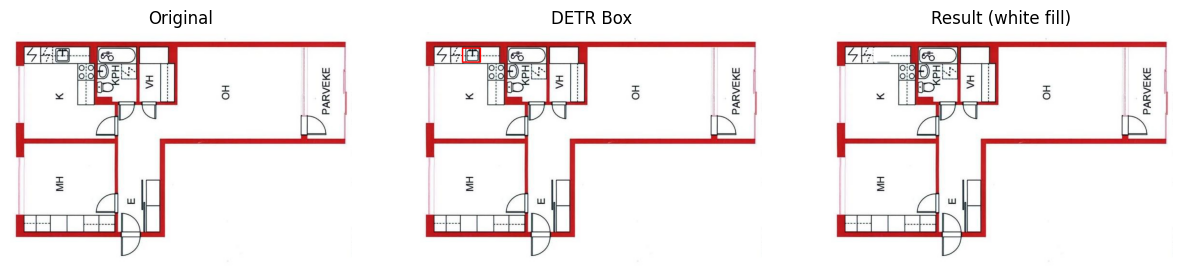

DONE ✅


In [10]:
import os, gc
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
IMAGE_PATH      = r".\TestPlans\testPlan3.PNG"

TARGET_LABEL_SUBSTR = "sink"
DETR_THRESH = 0.25

# White fill control
BOX_PAD = 2   # expand a bit to cover lines
OUT_DIR = "outputs_remove_sink_white_box"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def draw_box(img_pil, box, color=(255,0,0), thickness=2):
    arr = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(arr, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(arr)

# =========================
# 1) DETR detect sink
# =========================
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

# collect sink detections
cands = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    if TARGET_LABEL_SUBSTR.lower() not in name.lower():
        continue
    b = bx.detach().cpu().numpy()
    x0,y0,x1,y1 = b
    area = max(1.0, (x1-x0)*(y1-y0))
    cands.append((float(sc), float(area), b, name))

del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

if not cands:
    raise RuntimeError("No sink detected. Lower DETR_THRESH (0.15).")

# choose best by score then area
cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
best_score, best_area, best_box, best_name = cands[0]
box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)

print(f"✅ Using {best_name}: score={best_score:.2f}, area={best_area:.1f}, box={box}")

# =========================
# 2) Fill the box with white
# =========================
out = np.array(image_pil).copy()
x0,y0,x1,y1 = box

# pure white fill
out[y0:y1, x0:x1] = 255

out_pil = Image.fromarray(out)

# save
image_pil.save(os.path.join(OUT_DIR, "orig.png"))
draw_box(image_pil, box).save(os.path.join(OUT_DIR, "box.png"))
out_pil.save(os.path.join(OUT_DIR, "result.png"))

# show
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(1,3,2); plt.title("DETR Box"); plt.imshow(draw_box(image_pil, box)); plt.axis("off")
plt.subplot(1,3,3); plt.title("Result (white fill)"); plt.imshow(out_pil); plt.axis("off")
plt.show()

print("DONE ✅")


WINNING CODE


train_data/backgrounds

הקוד הבא:

מזהה אובייקט SINK


יוצר מסכה (אפשר box או SAM)

בוחר רקע לבן אקראי מהתיקייה שלך

“מדביק” אותו רק בתוך המסכה

DEVICE: cuda


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model,

✅ Using sink: score=0.72, area=817.1, box=[88, 33, 125, 62]


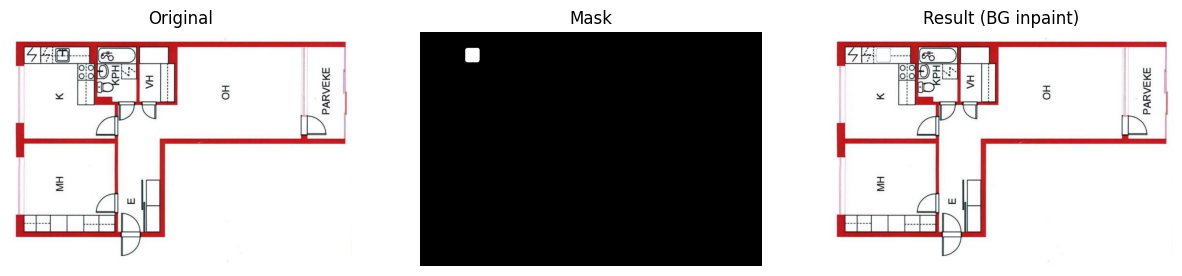

✅ Saved to outputs_inpaint_from_backgrounds: orig.png, box.png, mask.png, bg_used.png, result.png
DONE ✅


In [ ]:
import os, random, gc
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection
from segment_anything import sam_model_registry, SamPredictor

# =========================
# CONFIG
# =========================
IMAGE_PATH      = r".\TestPlans\testPlan3.PNG"
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
SAM_CHECKPOINT  = r".\checkpoints\sam_vit_h_4b8939.pth"

BACKGROUNDS_DIR = r".\train_data\backgrounds"   

TARGET_LABEL_SUBSTR = "sink"   # "stove" / "sink" / "toilet"
DETR_THRESH = 0.25

USE_SAM_MASK = True   # True = more precise (if SAM works), False = box mask (always stable)
BOX_PAD = 2            # used in box mask, and also for SAM box

OUT_DIR = "outputs_inpaint_from_backgrounds"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp")
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def pick_background(bg_dir):
    files = list_images(bg_dir)
    if not files:
        raise RuntimeError(f"No images found in {bg_dir}")
    return Image.open(random.choice(files)).convert("RGB")

def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return np.array([x0,y0,x1,y1], dtype=np.int32)

def draw_box(img_pil, box, color=(255,0,0), thickness=2):
    arr = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(arr, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(arr)

def box_mask(H, W, box):
    x0,y0,x1,y1 = map(int, box)
    m = np.zeros((H,W), dtype=np.uint8)
    m[y0:y1, x0:x1] = 255
    return m

def alpha_blend_with_mask(src_rgb, bg_rgb, mask_uint8):
    """
    src_rgb, bg_rgb: uint8 HxWx3
    mask_uint8: uint8 HxW (0..255)
    """
    m = (mask_uint8.astype(np.float32) / 255.0)[..., None]
    out = (src_rgb.astype(np.float32) * (1.0 - m) + bg_rgb.astype(np.float32) * m)
    return np.clip(out, 0, 255).astype(np.uint8)

# =========================
# 1) DETR detect target
# =========================
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

# collect candidates
cands = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    if TARGET_LABEL_SUBSTR.lower() not in name.lower():
        continue
    b = bx.detach().cpu().numpy()
    x0,y0,x1,y1 = b
    area = max(1.0, (x1-x0)*(y1-y0))
    cands.append((float(sc), float(area), b, name))

# cleanup DETR
del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

if not cands:
    raise RuntimeError(f"No '{TARGET_LABEL_SUBSTR}' detected. Lower DETR_THRESH or adjust label substring.")

cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
best_score, best_area, best_box, best_name = cands[0]

best_box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)
print(f"✅ Using {best_name}: score={best_score:.2f}, area={best_area:.1f}, box={best_box.tolist()}")

# =========================
# 2) Build mask (box or SAM)
# =========================
img_np = np.array(image_pil)

if not USE_SAM_MASK:
    mask = box_mask(H, W, best_box)
else:
    sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT).to(DEVICE)
    predictor = SamPredictor(sam)
    predictor.set_image(img_np, image_format="RGB")

    masks, _, _ = predictor.predict(
        box=best_box.astype(np.float32)[None, :],
        multimask_output=False
    )
    mask = (masks[0].astype(np.uint8) * 255)

    del sam, predictor
    torch.cuda.empty_cache(); gc.collect()

# =========================
# 3) Fill from your backgrounds folder
# =========================
bg_pil = pick_background(BACKGROUNDS_DIR)

# Resize chosen background to match image
bg_pil = bg_pil.resize((W, H), Image.Resampling.LANCZOS)

bg_np = np.array(bg_pil)

# Optional: feather mask to avoid hard edges
mask_feather = cv2.GaussianBlur(mask, (0,0), sigmaX=1.0)

out_np = alpha_blend_with_mask(img_np, bg_np, mask_feather)
out_pil = Image.fromarray(out_np)

# =========================
# Save + Show
# =========================
image_pil.save(os.path.join(OUT_DIR, "orig.png"))
draw_box(image_pil, best_box).save(os.path.join(OUT_DIR, "box.png"))
Image.fromarray(mask).save(os.path.join(OUT_DIR, "mask.png"))
bg_pil.save(os.path.join(OUT_DIR, "bg_used.png"))
out_pil.save(os.path.join(OUT_DIR, "result.png"))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(1,3,2); plt.title("Mask"); plt.imshow(mask, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Result (BG inpaint)"); plt.imshow(out_pil); plt.axis("off")
plt.show()

print(f"✅ Saved to {OUT_DIR}: orig.png, box.png, mask.png, bg_used.png, result.png")
print("DONE ✅")


אותו קוד רק העלמת ארון

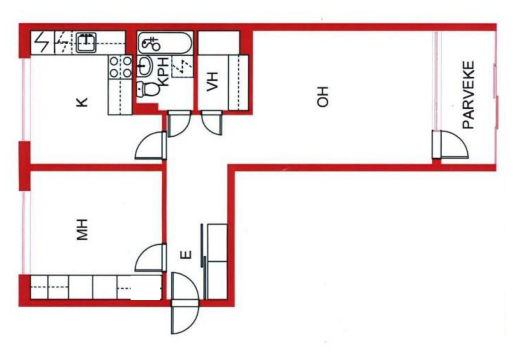

✅ Closet removed


In [17]:
import os, random, gc
import numpy as np
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
IMAGE_PATH      = r".\TestPlans\testPlan3.PNG"
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
BACKGROUNDS_DIR = r".\train_data\backgrounds"

TARGET_LABEL = "closet"
DETR_THRESH  = 0.25
BOX_PAD      = 2

OUT_DIR = "outputs_remove_closet"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# Helpers
# =========================
def pick_random_bg(folder, size):
    files = [f for f in os.listdir(folder) if f.lower().endswith((".png",".jpg",".jpeg"))]
    bg = Image.open(os.path.join(folder, random.choice(files))).convert("RGB")
    return bg.resize(size, Image.Resampling.LANCZOS)

def expand_box(box, W, H, pad):
    x0,y0,x1,y1 = box
    return [
        max(0, int(x0-pad)), max(0, int(y0-pad)),
        min(W, int(x1+pad)), min(H, int(y1+pad))
    ]

# =========================
# DETR
# =========================
image = Image.open(IMAGE_PATH).convert("RGB")
W, H = image.size

processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
model = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = model.config.id2label

inputs = processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([image.size[::-1]]).to(DEVICE),
    threshold=DETR_THRESH
)[0]

# pick closet
box = None
for score, lab, b in zip(results["scores"], results["labels"], results["boxes"]):
    if id2label[int(lab)] == TARGET_LABEL:
        box = b.cpu().numpy()
        break

if box is None:
    raise RuntimeError("No closet detected")

box = expand_box(box, W, H, BOX_PAD)
bg = pick_random_bg(BACKGROUNDS_DIR, image.size)

# apply
img_np = np.array(image)
bg_np  = np.array(bg)
x0,y0,x1,y1 = box
img_np[y0:y1, x0:x1] = bg_np[y0:y1, x0:x1]

out = Image.fromarray(img_np)
out.save(os.path.join(OUT_DIR, "result.png"))

plt.imshow(out); plt.axis("off"); plt.show()
print("✅ Closet removed")


העלמת דלת

DEVICE: cuda
✅ Removing 1stdoor: score=0.99, area=1930.4, box=[177, 169, 224, 214]


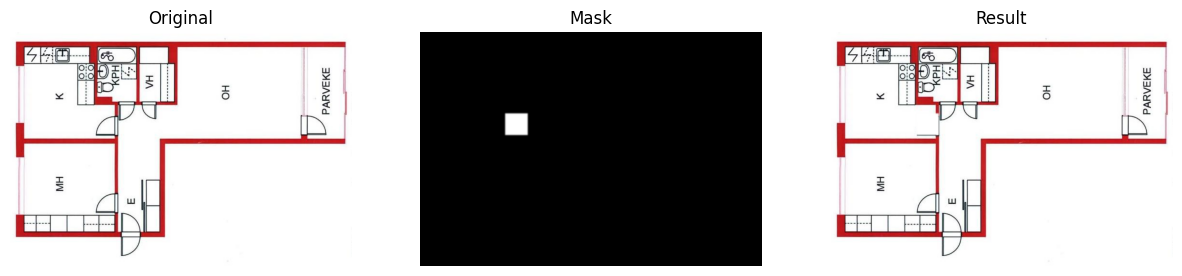

✅ Saved to outputs_remove_door_bg: orig.png, box.png, mask.png, bg_used.png, result.png
DONE ✅


In [21]:
import os, random, gc
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
IMAGE_PATH      = r".\TestPlans\testPlan3.PNG"
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
BACKGROUNDS_DIR = r".\train_data\backgrounds"

# Choose which door to remove:
TARGET_LABEL = "1stdoor"   # or "2sdoor"
DETR_THRESH  = 0.25

# Fill control
BOX_PAD = 1          # expands deletion region a bit
FEATHER_SIGMA = 1.2  # soft edge to blend background (0 to disable)

OUT_DIR = "outputs_remove_door_bg"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp")
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def pick_background(bg_dir, size_wh):
    files = list_images(bg_dir)
    if not files:
        raise RuntimeError(f"No background images found in {bg_dir}")
    bg = Image.open(random.choice(files)).convert("RGB")
    return bg.resize(size_wh, Image.Resampling.LANCZOS)

def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def draw_box(img_pil, box, color=(255,0,0), thickness=2):
    arr = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(arr, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(arr)

def alpha_blend(src, bg, mask_uint8):
    m = (mask_uint8.astype(np.float32) / 255.0)[..., None]
    out = src.astype(np.float32) * (1.0 - m) + bg.astype(np.float32) * m
    return np.clip(out, 0, 255).astype(np.uint8)

# =========================
# 1) DETR detect door
# =========================
image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size

processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

# Collect all doors of that label
cands = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    if name != TARGET_LABEL:
        continue
    b = bx.detach().cpu().numpy()
    x0,y0,x1,y1 = b
    area = max(1.0, (x1-x0)*(y1-y0))
    cands.append((float(sc), float(area), b))

# Cleanup DETR
del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

if not cands:
    raise RuntimeError(f"No '{TARGET_LABEL}' detected. Try DETR_THRESH=0.15 or verify label exists.")

# Choose best by score then area
cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
best_score, best_area, best_box = cands[0]
best_box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)

print(f"✅ Removing {TARGET_LABEL}: score={best_score:.2f}, area={best_area:.1f}, box={best_box}")

# =========================
# 2) Background inpaint inside (soft) box mask
# =========================
bg_pil = pick_background(BACKGROUNDS_DIR, (W, H))

src = np.array(image_pil)
bg  = np.array(bg_pil)

mask = np.zeros((H, W), dtype=np.uint8)
x0,y0,x1,y1 = best_box
mask[y0:y1, x0:x1] = 255

# Feather edges so it blends nicely
if FEATHER_SIGMA and FEATHER_SIGMA > 0:
    mask = cv2.GaussianBlur(mask, (0,0), sigmaX=float(FEATHER_SIGMA))

out_np = alpha_blend(src, bg, mask)
out_pil = Image.fromarray(out_np)

# =========================
# Save + Show
# =========================
image_pil.save(os.path.join(OUT_DIR, "orig.png"))
draw_box(image_pil, best_box).save(os.path.join(OUT_DIR, "box.png"))
Image.fromarray(mask).save(os.path.join(OUT_DIR, "mask.png"))
bg_pil.save(os.path.join(OUT_DIR, "bg_used.png"))
out_pil.save(os.path.join(OUT_DIR, "result.png"))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(1,3,2); plt.title("Mask"); plt.imshow(mask, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Result"); plt.imshow(out_pil); plt.axis("off")
plt.show()

print(f"✅ Saved to {OUT_DIR}: orig.png, box.png, mask.png, bg_used.png, result.png")
print("DONE ✅")


ניסוי: לעשות את אותו הנוהל רק לכל הLABELS

# Floorplan Object Removal with DETR + SAM + Background Inpainting

This script automatically detects and removes specific objects from architectural floorplans  
(e.g. doors, toilets, stoves, closets) by replacing them with background content.

The process is fully automatic, robust to missing objects, and supports multiple labels in one run.

---

## ✨ Features

- Detects multiple object types in a single floorplan
- Uses a fine-tuned **DETR** model for object detection
- Uses **SAM (Segment Anything)** for precise object masks
- Falls back to bounding-box masks if SAM fails
- Replaces objects using random background images
- Does **not crash** if an object is not found
- Saves outputs per label: bounding box, mask, background, and final result

---

## 🎯 Supported Object Labels

The script processes the following labels (substring matching):

- `1stdoor`
- `2sdoor`
- `toilet`
- `stove`
- `closet`
- `sink`

If a label is **not detected** in the floorplan, the script logs a warning and continues.

---

## 🧠 Pipeline Overview

1. **Object Detection**
   - Run DETR once on the input floorplan
   - Collect all detections above a confidence threshold

2. **Per-Label Processing**
   - Filter detections by label substring
   - Select the best candidate (highest score + largest area)

3. **Mask Generation**
   - Preferred: SAM segmentation using bounding box
   - Fallback: rectangular bounding-box mask

4. **Background Inpainting**
   - Random background selected from a folder
   - Mask is feathered for smooth blending
   - Object area is replaced with background pixels

5. **Result Saving**
   - Outputs saved per label in separate folders

---

## 📁 Output Structure

```text
outputs_inpaint_from_backgrounds_all_labels/
│
├── orig.png
│
├── toilet/
│   ├── box.png
│   ├── mask.png
│   ├── bg_used.png
│   └── result.png
│
├── stove/
│   ├── box.png
│   ├── mask.png
│   ├── bg_used.png
│   └── result.png
│
├── closet/
│   └── ...


DEVICE: cuda
Found 15 detections above threshold=0.25
✅ '1stdoor' -> using 1stdoor: score=0.98, area=3165.7, box=[481, 212, 541, 272]


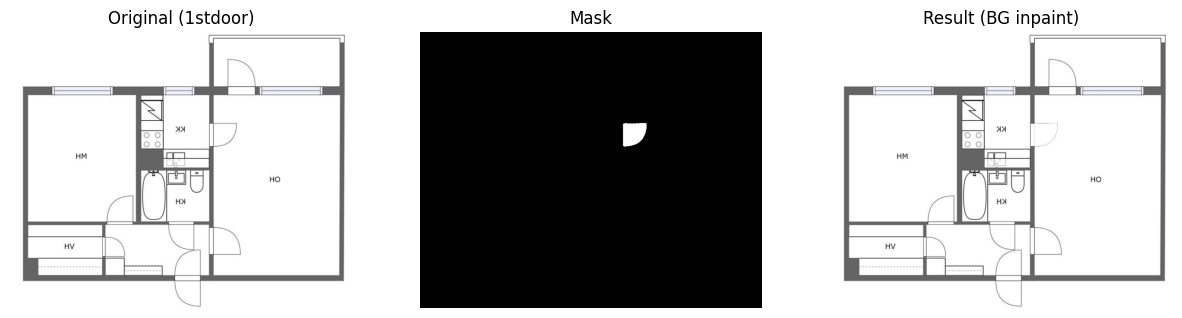

✅ '2sdoor' -> using 2sdoor: score=0.95, area=6702.7, box=[397, 520, 455, 649]


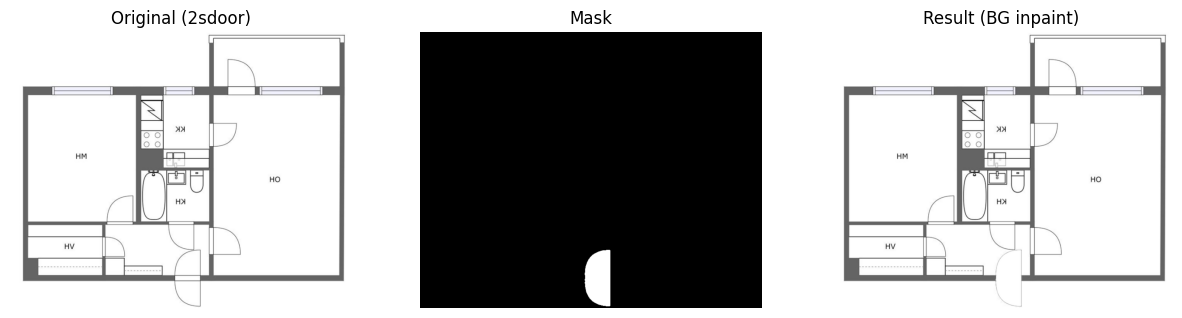

⚠️ Not found: 'toilet' (no detections). Skipping.
✅ 'stove' -> using stove: score=0.57, area=2063.8, box=[307, 231, 357, 280]


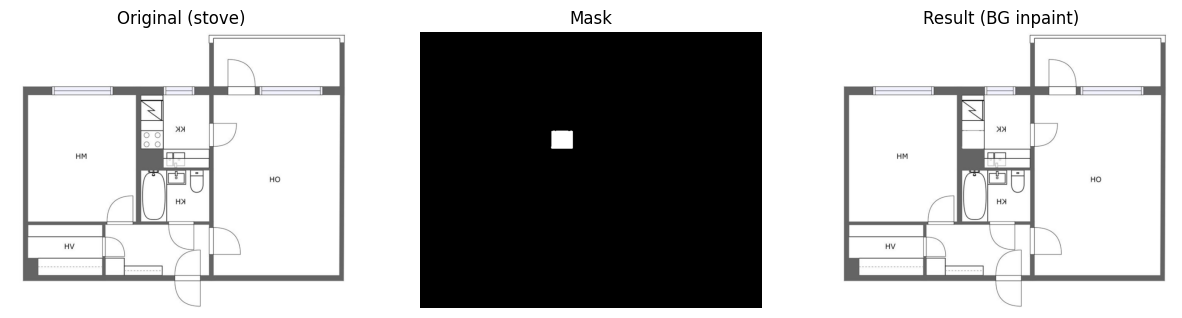

✅ 'closet' -> using closet: score=0.91, area=5086.0, box=[81, 534, 212, 578]


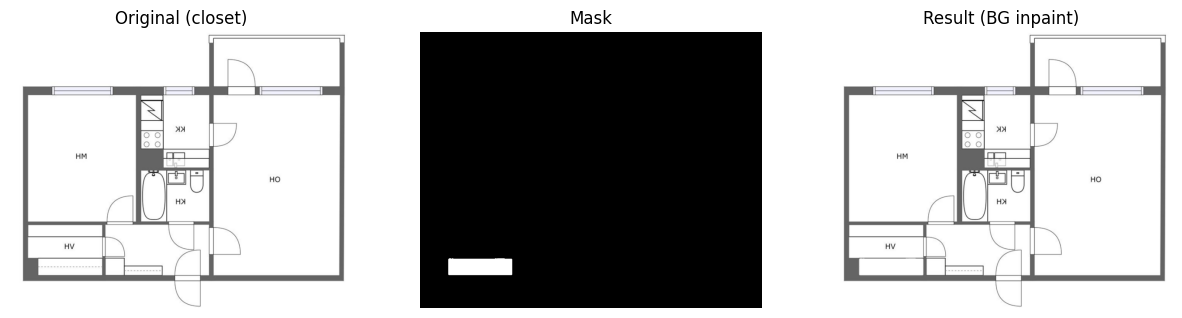

✅ 'sink' -> using sink: score=0.79, area=1501.7, box=[361, 278, 412, 314]


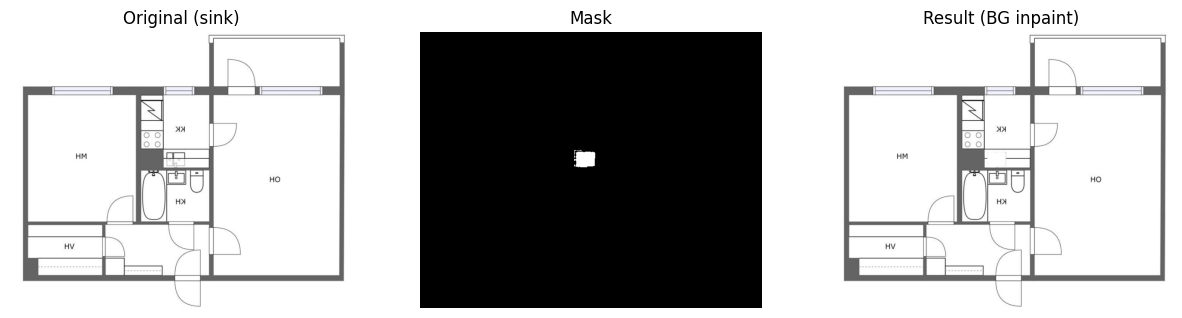


DONE ✅ Saved everything under: outputs_inpaint_from_backgrounds_all_labels


In [28]:
import os, random, gc, re
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection
from segment_anything import sam_model_registry, SamPredictor

# =========================
# CONFIG
# =========================
IMAGE_PATH      = r".\TestPlans\testPlan.PNG"
DETR_MODEL_PATH = r".\Model\detr-finetuned-floorplans"
SAM_CHECKPOINT  = r".\checkpoints\sam_vit_h_4b8939.pth"

BACKGROUNDS_DIR = r".\train_data\backgrounds"

TARGET_LABELS = ["1stdoor", "2sdoor", "toilet", "stove", "closet", "sink"]  # run all of these
DETR_THRESH = 0.25

USE_SAM_MASK = True   # True = more precise (if SAM works), False = box mask
BOX_PAD = 2           # padding for box + SAM box

OUT_DIR = "outputs_inpaint_from_backgrounds_all_labels"
os.makedirs(OUT_DIR, exist_ok=True)

SHOW_EACH = True     # True => show 3 images per label (can be slow)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp")
    if not os.path.isdir(folder):
        return []
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def pick_background(bg_dir):
    files = list_images(bg_dir)
    if not files:
        raise RuntimeError(f"No images found in {bg_dir}")
    return Image.open(random.choice(files)).convert("RGB")

def expand_box_xyxy(box, W, H, pad):
    x0, y0, x1, y1 = box
    x0 = max(0, int(x0 - pad)); y0 = max(0, int(y0 - pad))
    x1 = min(W, int(x1 + pad)); y1 = min(H, int(y1 + pad))
    return np.array([x0, y0, x1, y1], dtype=np.int32)

def draw_box(img_pil, box, color=(255, 0, 0), thickness=2):
    arr = np.array(img_pil).copy()
    x0, y0, x1, y1 = map(int, box)
    cv2.rectangle(arr, (x0, y0), (x1, y1), color, thickness)
    return Image.fromarray(arr)

def box_mask(H, W, box):
    x0, y0, x1, y1 = map(int, box)
    m = np.zeros((H, W), dtype=np.uint8)
    m[y0:y1, x0:x1] = 255
    return m

def alpha_blend_with_mask(src_rgb, bg_rgb, mask_uint8):
    """
    src_rgb, bg_rgb: uint8 HxWx3
    mask_uint8: uint8 HxW (0..255)
    """
    m = (mask_uint8.astype(np.float32) / 255.0)[..., None]
    out = (src_rgb.astype(np.float32) * (1.0 - m) + bg_rgb.astype(np.float32) * m)
    return np.clip(out, 0, 255).astype(np.uint8)

def safe_name(s: str) -> str:
    s = s.strip()
    s = re.sub(r"[^\w\-\.]+", "_", s)
    return s[:80] if len(s) > 80 else s

# =========================
# Load image once
# =========================
image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size
img_np = np.array(image_pil)

# Save original once
image_pil.save(os.path.join(OUT_DIR, "orig.png"))

# =========================
# 1) DETR detect (single forward pass)
# =========================
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=DETR_THRESH
)[0]

# Collect all detections once
all_dets = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    b = bx.detach().cpu().numpy()
    x0, y0, x1, y1 = b
    area = max(1.0, (x1 - x0) * (y1 - y0))
    all_dets.append((float(sc), float(area), b, name))

print(f"Found {len(all_dets)} detections above threshold={DETR_THRESH}")

# =========================
# 2) Init SAM once (optional)
# =========================
predictor = None
sam = None
if USE_SAM_MASK:
    sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT).to(DEVICE)
    predictor = SamPredictor(sam)
    predictor.set_image(img_np, image_format="RGB")

# =========================
# 3) Loop over target labels
# =========================
for target_substr in TARGET_LABELS:
    # Filter candidates by substring match
    cands = []
    for sc, area, b, name in all_dets:
        if target_substr.lower() in name.lower():
            cands.append((sc, area, b, name))

    if not cands:
        print(f"⚠️ Not found: '{target_substr}' (no detections). Skipping.")
        continue

    # pick best: highest score then largest area
    cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
    best_score, best_area, best_box, best_name = cands[0]
    best_box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)

    print(f"✅ '{target_substr}' -> using {best_name}: score={best_score:.2f}, area={best_area:.1f}, box={best_box.tolist()}")

    # Build mask
    if not USE_SAM_MASK:
        mask = box_mask(H, W, best_box)
    else:
        try:
            masks, _, _ = predictor.predict(
                box=best_box.astype(np.float32)[None, :],
                multimask_output=False
            )
            mask = (masks[0].astype(np.uint8) * 255)
        except Exception as e:
            # fall back to box mask, don't crash
            print(f"⚠️ SAM failed for '{target_substr}' ({e}). Falling back to box mask.")
            mask = box_mask(H, W, best_box)

    # Background + blend
    try:
        bg_pil = pick_background(BACKGROUNDS_DIR).resize((W, H), Image.Resampling.LANCZOS)
    except Exception as e:
        print(f"⚠️ Background loading failed ({e}). Skipping '{target_substr}'.")
        continue

    bg_np = np.array(bg_pil)

    # Feather edges
    mask_feather = cv2.GaussianBlur(mask, (0, 0), sigmaX=1.0)

    out_np = alpha_blend_with_mask(img_np, bg_np, mask_feather)
    out_pil = Image.fromarray(out_np)

    # Save per-label outputs
    lbl_dir = os.path.join(OUT_DIR, safe_name(target_substr))
    os.makedirs(lbl_dir, exist_ok=True)

    draw_box(image_pil, best_box).save(os.path.join(lbl_dir, "box.png"))
    Image.fromarray(mask).save(os.path.join(lbl_dir, "mask.png"))
    bg_pil.save(os.path.join(lbl_dir, "bg_used.png"))
    out_pil.save(os.path.join(lbl_dir, "result.png"))

    if SHOW_EACH:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1); plt.title(f"Original ({target_substr})"); plt.imshow(image_pil); plt.axis("off")
        plt.subplot(1, 3, 2); plt.title("Mask"); plt.imshow(mask, cmap="gray"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.title("Result (BG inpaint)"); plt.imshow(out_pil); plt.axis("off")
        plt.show()

# =========================
# Cleanup
# =========================
try:
    del inputs, outputs, detr, processor
except:
    pass

if predictor is not None:
    try:
        del predictor, sam
    except:
        pass

torch.cuda.empty_cache()
gc.collect()

print(f"\nDONE ✅ Saved everything under: {OUT_DIR}")
